# Label scores analyses

This notebook performs the following analysis steps:
* aggregating data across seeds, by phenomenon, by model, by label type
* transforming raw metrics into probabilities by item by metric
    * this requires working by-phenomenon, because there are different numbers of options in the different phenomena
* combining this data into one cleaned data file with binarized options (probabilities of target vs rest)
    * long formatting of options and of metrics
* averaging probabilities across items and across seeds, by metric, by model, by phenomenon, by label type
* plotting results by metric, by phenomenon, by model, by label type

In [372]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import random

In [377]:
# read data and combine
model_names = ["llama2", "flan-t5-xl", "gpt-3.5-turbo-instruct", "text-davinci-002"]
label_types = ["label_alpha", "label_numeric"]

raw_df = pd.DataFrame()
# t5_tokens = pd.DataFrame()
for model in model_names:
    print("Model ", model)
    for label_type in label_types:
        results_path = glob.glob(f"../results/log_probs/{model}/*/label_scores/{label_type}/*.csv")
#         results_path = glob.glob(f"../../tokens/seed0/string_scores/label_alpha/*.csv")
        print("Number of files to concat ", len(results_path))
        for p in results_path:
#             print("Reading file ", p)
            d = pd.read_csv(p)
            d["metric"] = "label_score"
            d["label_type"] = label_type
            
            raw_df = pd.concat([raw_df, d])    
#             t5_tokens = pd.concat([t5_tokens, d])    

Model  llama2
Number of files to concat  35
Number of files to concat  35
Model  flan-t5-xl
Number of files to concat  35
Number of files to concat  35
Model  gpt-3.5-turbo-instruct
Number of files to concat  35
Number of files to concat  31
Model  text-davinci-002
Number of files to concat  35
Number of files to concat  35


In [378]:
print(len(raw_df))
raw_df.head()

25740


,model_name,temperature,seed,item_id,phenomenon,prompt,prior_prompt,question,options,option_names,...,token_probs,sentence_cond_probs,mean_sentence_cond_probs,prior_sentence_probs,sentence_mi,sentence_surprisal,mean_sentence_surprisal,sentence_mi_surprisal,metric,label_type
0,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,A,target,...,[0.0021805406873923253],0.003313,0.003313,0.002181,1.519248,-5.709967,-5.709967,0.931755,label_score,label_alpha
1,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,B,incorrect_straightforward,...,[0.0018741641342209612],0.002067,0.002067,0.001874,1.103044,-6.181519,-6.181519,0.984382,label_score,label_alpha
2,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,C,associative_nonsequitur,...,[0.003587298613933627],0.001646,0.001646,0.003587,0.458951,-6.409168,-6.409168,1.138324,label_score,label_alpha
3,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,D,funny_nonsequitur,...,[0.002218916267492813],0.001804,0.001804,0.002219,0.812816,-6.317986,-6.317986,1.033916,label_score,label_alpha
4,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,E,neutral_nonsequitur,...,[0.0014657024465339016],0.000984,0.000984,0.001466,0.671308,-6.923948,-6.923948,1.061073,label_score,label_alpha


In [380]:
def compute_mi_on_logs(lik, prior):
    """
    Helper for computing proir correction metric on
    sentence log probabilities.
    """
    return lik - prior

In [381]:
# recompute the sentence MI on log probs (error in raw saved data)
raw_df.columns
raw_df["null_sentence_surprisal"] = raw_df["null_prior_token_log_probs"].apply(
    lambda s: sum([float(x.strip()) for x in s.replace("[", "").replace("]", "").split(",")])
)
raw_df["sentence_mi_surprisal_corrected"] = raw_df.apply(
    lambda r: compute_mi_on_logs(r["sentence_surprisal"], r["null_sentence_surprisal"]), axis = 1
)
raw_df.head()

,model_name,temperature,seed,item_id,phenomenon,prompt,prior_prompt,question,options,option_names,...,mean_sentence_cond_probs,prior_sentence_probs,sentence_mi,sentence_surprisal,mean_sentence_surprisal,sentence_mi_surprisal,metric,label_type,null_sentence_surprisal,sentence_mi_surprisal_corrected
0,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,A,target,...,0.003313,0.002181,1.519248,-5.709967,-5.709967,0.931755,label_score,label_alpha,-6.128182,0.418216
1,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,B,incorrect_straightforward,...,0.002067,0.001874,1.103044,-6.181519,-6.181519,0.984382,label_score,label_alpha,-6.279593,0.098074
2,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,C,associative_nonsequitur,...,0.001646,0.003587,0.458951,-6.409168,-6.409168,1.138324,label_score,label_alpha,-5.630356,-0.778812
3,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,D,funny_nonsequitur,...,0.001804,0.002219,0.812816,-6.317986,-6.317986,1.033916,label_score,label_alpha,-6.110736,-0.207250
4,meta-llama/Llama-2-7b-hf,0.1,3,1,humour,You will read a joke that is missing its punch...,You will read a joke that is missing its punch...,NaN,E,neutral_nonsequitur,...,0.000984,0.001466,0.671308,-6.923948,-6.923948,1.061073,label_score,label_alpha,-6.525421,-0.398527


In [315]:
t5_tokens.head()

,model_name,temperature,seed,item_id,phenomenon,prompt,prior_prompt,question,options,option_names,...,token_probs,sentence_cond_probs,mean_sentence_cond_probs,prior_sentence_probs,sentence_mi,sentence_surprisal,mean_sentence_surprisal,sentence_mi_surprisal,metric,label_type
0,google/flan-t5-xl,0.1,0,1,coherence,You will read a pair of sentences. Your task i...,You will read a pair of sentences. Your task i...,Is this story coherent or not?,coherent,target,...,[4.3703696853810595e-06],0.000135,0.000135,0.000004,30.820167,-8.912494,-8.912494,0.722205,label_score,label_alpha
1,google/flan-t5-xl,0.1,0,1,coherence,You will read a pair of sentences. Your task i...,You will read a pair of sentences. Your task i...,Is this story coherent or not?,incoherent,competitor,...,"[0.0047632747355670245, 0.9991747995713526, 0....",0.000293,0.747518,0.004682,0.062515,-8.136388,-2.034097,1.516839,label_score,label_alpha
2,google/flan-t5-xl,0.1,0,2,coherence,You will read a pair of sentences. Your task i...,You will read a pair of sentences. Your task i...,Is this story coherent or not?,coherent,target,...,[4.3703696853810595e-06],0.000072,0.000072,0.000004,16.374260,-9.544952,-9.544952,0.773455,label_score,label_alpha
3,google/flan-t5-xl,0.1,0,2,coherence,You will read a pair of sentences. Your task i...,You will read a pair of sentences. Your task i...,Is this story coherent or not?,incoherent,competitor,...,"[0.0047632747355670245, 0.9991747995713526, 0....",0.000096,0.745279,0.004682,0.020489,-9.251887,-2.312972,1.724798,label_score,label_alpha
4,google/flan-t5-xl,0.1,0,3,coherence,You will read a pair of sentences. Your task i...,You will read a pair of sentences. Your task i...,Is this story coherent or not?,coherent,target,...,[4.3703696853810595e-06],0.000069,0.000069,0.000004,15.738774,-9.584536,-9.584536,0.776663,label_score,label_alpha


In [253]:
raw_df.columns

Index(['model_name', 'temperature', 'seed', 'item_id', 'phenomenon', 'prompt',
       'prior_prompt', 'question', 'options', 'option_names',
       'shuffled_options', 'shuffled_option_names', 'option_numbering',
       'token_cond_log_probs', 'token_cond_probs', 'prior_token_log_probs',
       'null_prior_token_log_probs', 'token_probs', 'sentence_cond_probs',
       'mean_sentence_cond_probs', 'prior_sentence_probs', 'sentence_mi',
       'sentence_surprisal', 'mean_sentence_surprisal',
       'sentence_mi_surprisal', 'metric', 'label_type'],
      dtype='object')

In [389]:
coherence_df = raw_df[raw_df['phenomenon'] == 'coherence']
deceits_df = raw_df[raw_df['phenomenon'] == 'deceits']
humours_df = raw_df[raw_df['phenomenon'] == 'humour']
indirect_df = raw_df[raw_df['phenomenon'] == 'indirect_speech']
irony_df = raw_df[raw_df['phenomenon'] == 'irony']
maxims_df = raw_df[raw_df['phenomenon'] == 'maxims']
metaphor_df = raw_df[raw_df['phenomenon'] == 'metaphor']

In [316]:
# same with T5 data which was pulled with the by-token masking
coherence_df5 = t5_tokens[t5_tokens['phenomenon'] == 'coherence']
deceits_df5 = t5_tokens[t5_tokens['phenomenon'] == 'deceits']
humours_df5 = t5_tokens[t5_tokens['phenomenon'] == 'humour']
indirect_df5 = t5_tokens[t5_tokens['phenomenon'] == 'indirect_speech']
irony_df5 = t5_tokens[t5_tokens['phenomenon'] == 'irony']
maxims_df5 = t5_tokens[t5_tokens['phenomenon'] == 'maxims']
metaphor_df5 = t5_tokens[t5_tokens['phenomenon'] == 'metaphor']

For the sanity check, here are the expected numbers of rows in each phenomenon, computed as: models * seed * items * options

* coherence: 4 * 5 * 40 * 2 = 1200 => 2400
* deceits: 4 * 5 * 20 * 4 = 1200 => 2400
* humour: 4 * 5 * 25 * 5 = 1875 => 3750
* indirect: 4 * 5 * 20 * 4 = 1200 => 2400
* irony: 4 * 5 * 25 * 4 = 1500 => 3000
* maxims: 4 * 5 * 19 * 4 = 1140 => 2280
* metaphor: 4 * 5 * 20 * 5 = 1500 => 3000

And for each x 2 for the numeric and alpha labels.

In [396]:
# somehow irony has 100 duplicate entries -- exclude
irony_df = irony_df.drop_duplicates()
len(irony_df)

4000

In [390]:
def identify_max(r, option_names):
    """
    Helper for retrieving name of option
    for which score was maximal for row r.
    """
    option_vals = [r[o] for o in option_names]
    # identiry max, otherwise random tie breaking
    if option_vals.count(max(option_vals)) > 1:
        # choose randomly amongst the max prob options
        max_options = [option_names[i] for i, j in enumerate(option_vals) if j == max(option_vals)]
        chosen_option = random.choice(max_options)
    else:
        chosen_option = option_names[
            option_vals.index(max(option_vals))
        ]
    return chosen_option

def transform_to_wide_and_softmax(df, option_names = ['target', 'competitor']):
    """
    Helper function for pivoting dataframes 
    to wide format and transforming metric results into 
    probabilities.
    Metric columns are collected into long format first for this.
    """
    # pivot all the metrics into one column
    df_subset = df[["model_name", "seed", "item_id", "phenomenon", "shuffled_option_names", "sentence_cond_probs", "mean_sentence_cond_probs", "sentence_mi", "sentence_surprisal", "mean_sentence_surprisal", "sentence_mi_surprisal_corrected", "metric", "label_type"]]
    df_subset = df_subset.rename(columns={
        "sentence_cond_probs": "value_sentence_cond_probs", 
        "mean_sentence_cond_probs": "value_mean_sentence_cond_probs", 
        "sentence_mi": "value_sentence_mi", 
        "sentence_surprisal": "value_sentence_surprisal", 
        "mean_sentence_surprisal": "value_mean_sentence_surprisal", 
        "sentence_mi_surprisal_corrected": "value_sentence_mi_surprisal"
    })
#     print(df_subset.head(5))
    df_long = pd.wide_to_long(
        df_subset, 
        stubnames="value_", 
        i=["model_name", "seed", "item_id", "phenomenon", "shuffled_option_names", "metric", "label_type"], 
        j="metric_formula",
        suffix='\\w+', 
    )
    df_long = df_long.reset_index()
    # fill NAs with 0
    df_long['value_'] = df_long["value_"].fillna(0)
    
    # spread different response options so that softmax can be applied
    df_wide = df_long.pivot_table(
        index=["model_name", "seed", "item_id", "phenomenon","metric", "label_type", "metric_formula"],
        columns="shuffled_option_names",
        values="value_"
    )
    df_wide = df_wide.reset_index()
    df_wide_raw = df_wide.copy()
    
    # softmax options over response option types
    df_wide["denominator"] = df_wide[option_names].sum(axis=1)
    for o in option_names:
        df_wide[o] = df_wide[o]/df_wide["denominator"]
    # additionally, pull option for which the value was maximal
    df_wide_raw["chosen_option"] = df_wide_raw.apply(
        lambda r: identify_max(r, option_names), 
        axis=1
    )
    
    return df_wide, df_wide_raw

In [393]:
def is_any_na(r, metric_formula=["sentence_cond_probs", "mean_sentence_cond_probs", "sentence_mi", "sentence_surprisal", "mean_sentence_surprisal", "sentence_mi_surprisal_corrected"]):
    return any([r[o] for o in metric_formula])

def check_na(df):
    """
    Helper for checking for NaNs.
    """
    df_subset = df[["sentence_cond_probs", "mean_sentence_cond_probs", "sentence_mi", "sentence_surprisal", "mean_sentence_surprisal", "sentence_mi_surprisal_corrected"]].isna()
    df_subset["is_any_na"] = df_subset.apply(lambda r: is_any_na(r), axis=1)
    
    return df_subset[df_subset['is_any_na'] == True]
    

In [394]:
# no NAs
check_na(metaphor_df)

,sentence_cond_probs,mean_sentence_cond_probs,sentence_mi,sentence_surprisal,mean_sentence_surprisal,sentence_mi_surprisal_corrected,is_any_na


In [397]:
# apply the helper to all phenomena (fist df is processed (i.e., softmaxed), second is raw)
# the second dataframe is the one that includes information about which option had the highest score ("chosen_option")
# therefore, this is used further
coherence_processed, coherence_processed_ = transform_to_wide_and_softmax(coherence_df)
deceits_processed, deceits_processed_ = transform_to_wide_and_softmax(deceits_df, ["target", "incorrect_literal", "incorrect_lexical_overlap", "incorrect_social_convention"])
humours_processed, humours_processed_ = transform_to_wide_and_softmax(humours_df, ["target", "incorrect_straightforward", "associative_nonsequitur", "funny_nonsequitur", "neutral_nonsequitur"])
indirect_processed, indirect_processed_ = transform_to_wide_and_softmax(indirect_df, ["target", "competitor", "distractor_lexical_overlap", "distractor_associative"])
irony_processed, irony_processed_ = transform_to_wide_and_softmax(irony_df, ["target", "competitor", "distractor_associate", "distractor_nonsequitur"])
maxims_processed, maxims_processed_ = transform_to_wide_and_softmax(maxims_df, ["target", "incorrect_literal", "incorrect_nonliteral", "incorrect_associate"])
metaphor_processed, metaphor_processed_ = transform_to_wide_and_softmax(metaphor_df, ["target", "competitor", "distractor_plausibleliteral", "distractor_literal", "distractor_nonsequitut"])

In [320]:
# same with token-level t5 data
_, coherence_processed_5 = transform_to_wide_and_softmax(coherence_df5)
_, deceits_processed_5 = transform_to_wide_and_softmax(deceits_df5, ["target", "incorrect_literal", "incorrect_lexical_overlap", "incorrect_social_convention"])
_, humours_processed_5 = transform_to_wide_and_softmax(humours_df5, ["target", "incorrect_straightforward", "associative_nonsequitur", "funny_nonsequitur", "neutral_nonsequitur"])
_, indirect_processed_5 = transform_to_wide_and_softmax(indirect_df5, ["target", "competitor", "distractor_lexical_overlap", "distractor_associative"])
_, irony_processed_5 = transform_to_wide_and_softmax(irony_df5, ["target", "competitor", "distractor_associate", "distractor_nonsequitur"])
_, maxims_processed_5 = transform_to_wide_and_softmax(maxims_df5, ["target", "incorrect_literal", "incorrect_nonliteral", "incorrect_associate"])
_, metaphor_processed_5 = transform_to_wide_and_softmax(metaphor_df5, ["target", "competitor", "distractor_plausibleliteral", "distractor_literal", "distractor_nonsequitut"])

In [398]:
# binarize the processed data into target vs non-target probability
# or into numerical representation of target vs non-target
def binarize_df(df, is_argmax=False):
    if is_argmax:
        df["correct"] = df["chosen_option"].apply(lambda s: int(s == "target"))
        df_subset = df[['metric_formula', "model_name", "seed", "item_id", "phenomenon", "metric", "label_type", "chosen_option", "correct"]]
    else: 
        df["distractor_prob"] = 1 - df["target"] 
        df_subset = df[['metric_formula', "model_name", "seed", "item_id", "phenomenon", "metric", "label_type", "target", "distractor_prob"]]
    
    return df_subset

In [261]:
humours_processed.head()

shuffled_option_names,model_name,seed,item_id,phenomenon,metric,label_type,metric_formula,associative_nonsequitur,funny_nonsequitur,incorrect_straightforward,neutral_nonsequitur,target,denominator
0,google/flan-t5-xl,0,1,humour,label_score,label_alpha,mean_sentence_cond_probs,0.016044,0.590647,0.327505,0.031325,0.034478,0.002620
1,google/flan-t5-xl,0,1,humour,label_score,label_alpha,mean_sentence_surprisal,0.238064,0.152877,0.166809,0.222258,0.219992,-42.328773
2,google/flan-t5-xl,0,1,humour,label_score,label_alpha,sentence_cond_probs,0.016044,0.590647,0.327505,0.031325,0.034478,0.002620
3,google/flan-t5-xl,0,1,humour,label_score,label_alpha,sentence_mi,0.163253,0.252531,0.220478,0.143632,0.220107,3.803416
4,google/flan-t5-xl,0,1,humour,label_score,label_alpha,sentence_mi_surprisal,0.203040,0.194651,0.198384,0.206723,0.197202,5.169620


In [399]:
# apply binarization
coherence_binary = binarize_df(coherence_processed_, is_argmax=True)
deceits_binary = binarize_df(deceits_processed_, is_argmax=True)
humours_binary = binarize_df(humours_processed_, is_argmax=True)
indirect_binary = binarize_df(indirect_processed_, is_argmax=True)
irony_binary = binarize_df(irony_processed_, is_argmax=True)
maxims_binary = binarize_df(maxims_processed_, is_argmax=True)
metaphor_binary = binarize_df(metaphor_processed_, is_argmax=True)

In [322]:
# apply binarization for the token-level retrieved T5 data
coherence_binary5 = binarize_df(coherence_processed_5, is_argmax=True)
deceits_binary5 = binarize_df(deceits_processed_5, is_argmax=True)
humours_binary5 = binarize_df(humours_processed_5, is_argmax=True)
indirect_binary5 = binarize_df(indirect_processed_5, is_argmax=True)
irony_binary5 = binarize_df(irony_processed_5, is_argmax=True)
maxims_binary5 = binarize_df(maxims_processed_5, is_argmax=True)
metaphor_binary5 = binarize_df(metaphor_processed_5, is_argmax=True)

In [400]:
# combine all into one cleaned file
label_scores = pd.concat([coherence_binary,deceits_binary,humours_binary,indirect_binary,irony_binary, maxims_binary,metaphor_binary])

In [323]:
# combine all T5 data produced with token-levle masking into one cleaned file
label_scores_t5_token = pd.concat([coherence_binary5,deceits_binary5,humours_binary5,indirect_binary5,irony_binary5, maxims_binary5,metaphor_binary5])

In [324]:
# compile T5 data only 
label_scores_t5 = label_scores[label_scores["model_name"] == "google/flan-t5-xl"]
label_scores_t5["masking"] = "word"
label_scores_t5_token["masking"] = "token"

t5_masking_comparison = pd.concat([
    label_scores_t5,
    label_scores_t5_token
])
t5_masking_comparison

/var/folders/fn/6ct_6l112376k8288ws7798m0000gn/T/ipykernel_50640/357883532.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_scores_t5["masking"] = "word"


shuffled_option_names,metric_formula,model_name,seed,item_id,phenomenon,metric,label_type,chosen_option,correct,masking
0,mean_sentence_cond_probs,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,target,1,word
1,mean_sentence_surprisal,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,target,1,word
2,sentence_cond_probs,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,target,1,word
3,sentence_mi,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,target,1,word
4,sentence_mi_surprisal,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,competitor,0,word
...,...,...,...,...,...,...,...,...,...,...
115,mean_sentence_surprisal,google/flan-t5-xl,0,20,metaphor,label_score,label_alpha,distractor_plausibleliteral,0,token
116,sentence_cond_probs,google/flan-t5-xl,0,20,metaphor,label_score,label_alpha,distractor_literal,0,token
117,sentence_mi,google/flan-t5-xl,0,20,metaphor,label_score,label_alpha,distractor_plausibleliteral,0,token
118,sentence_mi_surprisal,google/flan-t5-xl,0,20,metaphor,label_score,label_alpha,distractor_nonsequitut,0,token


In [350]:
# check how often words were actually tokenized into subword tokens:
t5_tokens["num_tokens"] = t5_tokens["token_probs"].apply(lambda s: len(s.split(",")))

# TODO read data for string scores computed with word based tokenization


# t5_token_nums = pd.align
placeholder = label_scores_t5_token.groupby(["phenomenon", "metric_formula"]).mean("correct").reset_index()
p2 = pd.read_csv("string_scores_accuracy_summary.csv")
p2 = p2[p2["model_name"] == "google/flan-t5-xl"]
l, r = placeholder.set_index(["phenomenon", "metric_formula"]).align(p2.set_index(["phenomenon", "metric_formula"]), axis=0)
# placeholder.to_csv("t5_tokenlevel_masking_summary.csv", index=False)

In [356]:
r

model_name        metric  \
phenomenon      metric_formula                                              
coherence       mean_sentence_cond_probs  google/flan-t5-xl  string_score   
                mean_sentence_surprisal   google/flan-t5-xl  string_score   
                sentence_cond_probs       google/flan-t5-xl  string_score   
                sentence_mi               google/flan-t5-xl  string_score   
                sentence_mi_surprisal     google/flan-t5-xl  string_score   
                sentence_surprisal        google/flan-t5-xl  string_score   
deceits         mean_sentence_cond_probs  google/flan-t5-xl  string_score   
                mean_sentence_surprisal   google/flan-t5-xl  string_score   
                sentence_cond_probs       google/flan-t5-xl  string_score   
                sentence_mi               google/flan-t5-xl  string_score   
                sentence_mi_surprisal     google/flan-t5-xl  string_score   
                sentence_surprisal        google/flan-t5-xl  string_score   
humour          mean_sentence_cond_probs  google/flan-t5-xl  string_score   
                mean_sentence_surprisal   google/flan-t5-xl  string_score   
                sentence_cond_probs       google/flan-t5-xl  string_score   
                sentence_mi               google/flan-t5-xl  string_score   
                sentence_mi_surprisal     google/flan-t5-xl  string_score   
                sentence_surprisal        google/flan-t5-xl  string_score   
indirect_speech mean_sentence_cond_probs  google/flan-t5-xl  string_score   
                mean_sentence_surprisal   google/flan-t5-xl  string_score   
                sentence_cond_probs       google/flan-t5-xl  string_score   
                sentence_mi               google/flan-t5-xl  string_score   
                sentence_mi_surprisal     google/flan-t5-xl  string_score   
                sentence_surprisal        google/flan-t5-xl  string_score   
irony           mean_sentence_cond_probs  google/flan-t5-xl  string_score   
                mean_sentence_surprisal   google/flan-t5-xl  string_score   
                sentence_cond_probs       google/flan-t5-xl  string_score   
                sentence_mi               google/flan-t5-xl  string_score   
                sentence_mi_surprisal     google/flan-t5-xl  string_score   
                sentence_surprisal        google/flan-t5-xl  string_score   
maxims          mean_sentence_cond_probs  google/flan-t5-xl  string_score   
                mean_sentence_surprisal   google/flan-t5-xl  string_score   
                sentence_cond_probs       google/flan-t5-xl  string_score   
                sentence_mi               google/flan-t5-xl  string_score   
                sentence_mi_surprisal     google/flan-t5-xl  string_score   
                sentence_surprisal        google/flan-t5-xl  string_score   
metaphor        mean_sentence_cond_probs  google/flan-t5-xl  string_score   
                mean_sentence_surprisal   google/flan-t5-xl  string_score   
                sentence_cond_probs       google/flan-t5-xl  string_score   
                sentence_mi               google/flan-t5-xl  string_score   
                sentence_mi_surprisal     google/flan-t5-xl  string_score   
                sentence_surprisal        google/flan-t5-xl  string_score   

                                          dependent_variable  
phenomenon      metric_formula                                
coherence       mean_sentence_cond_probs            0.550000  
                mean_sentence_surprisal             0.550000  
                sentence_cond_probs                 0.550000  
                sentence_mi                         0.775000  
                sentence_mi_surprisal               0.200000  
                sentence_surprisal                  0.550000  
deceits         mean_sentence_cond_probs            0.200000  
                mean_sentence_surprisal             0.200000  
                sentence_cond_

In [335]:
raw_df_t5
t5_tokens

,model_name,temperature,seed,item_id,phenomenon,prompt,prior_prompt,question,options,option_names,...,sentence_cond_probs,mean_sentence_cond_probs,prior_sentence_probs,sentence_mi,sentence_surprisal,mean_sentence_surprisal,sentence_mi_surprisal,metric,label_type,num_tokens
0,google/flan-t5-xl,0.1,0,1,coherence,You will read a pair of sentences. Your task i...,You will read a pair of sentences. Your task i...,Is this story coherent or not?,coherent,target,...,1.346955e-04,0.000135,4.370370e-06,3.082017e+01,-8.912494,-8.912494,0.722205,label_score,label_alpha,1
1,google/flan-t5-xl,0.1,0,1,coherence,You will read a pair of sentences. Your task i...,You will read a pair of sentences. Your task i...,Is this story coherent or not?,incoherent,competitor,...,2.926924e-04,0.747518,4.681945e-03,6.251513e-02,-8.136388,-2.034097,1.516839,label_score,label_alpha,4
2,google/flan-t5-xl,0.1,0,2,coherence,You will read a pair of sentences. Your task i...,You will read a pair of sentences. Your task i...,Is this story coherent or not?,coherent,target,...,7.156157e-05,0.000072,4.370370e-06,1.637426e+01,-9.544952,-9.544952,0.773455,label_score,label_alpha,1
3,google/flan-t5-xl,0.1,0,2,coherence,You will read a pair of sentences. Your task i...,You will read a pair of sentences. Your task i...,Is this story coherent or not?,incoherent,competitor,...,9.593043e-05,0.745279,4.681945e-03,2.048944e-02,-9.251887,-2.312972,1.724798,label_score,label_alpha,4
4,google/flan-t5-xl,0.1,0,3,coherence,You will read a pair of sentences. Your task i...,You will read a pair of sentences. Your task i...,Is this story coherent or not?,coherent,target,...,6.878426e-05,0.000069,4.370370e-06,1.573877e+01,-9.584536,-9.584536,0.776663,label_score,label_alpha,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,google/flan-t5-xl,0.1,0,20,metaphor,You will read a short story that describes an ...,You will read a short story that describes an ...,NaN,They are meant to be together.,target,...,2.012841e-04,0.508186,2.236906e-05,8.998326e+00,-8.510793,-1.215828,0.794819,label_score,label_alpha,7
96,google/flan-t5-xl,0.1,0,20,metaphor,You will read a short story that describes an ...,You will read a short story that describes an ...,NaN,He would love some pasta for dinner.,competitor,...,3.306908e-10,0.133075,1.917695e-08,1.724418e-02,-21.829837,-2.728730,1.228496,label_score,label_alpha,8
97,google/flan-t5-xl,0.1,0,20,metaphor,You will read a short story that describes an ...,You will read a short story that describes an ...,NaN,They enjoy Italian cuisine.,distractor_plausibleliteral,...,1.162988e-06,0.186315,3.704755e-06,3.139176e-01,-13.664518,-2.732904,1.092646,label_score,label_alpha,5
98,google/flan-t5-xl,0.1,0,20,metaphor,You will read a short story that describes an ...,You will read a short story that describes an ...,NaN,The tomato sauce that she makes goes well with...,distractor_literal,...,6.292296e-07,0.530420,1.056947e-13,5.953273e+06,-14.278770,-1.189897,0.477899,label_score,label_alpha,12


In [264]:
# label_scores.to_csv("../results/log_probs/label_scores_all_cleaned_argmax_binarized.csv", index=False)
label_scores.head()
len(label_scores)

40560

In [401]:
# analyse the data
# averaging probabilities across items and across seeds, by metric, by model, by phenomenon, by label type
# just for eyeballing
scores_binary_summary = label_scores.groupby(["model_name", "metric_formula", "phenomenon", "label_type"]).mean(["correct"]).reset_index()
scores_binary_summary 

shuffled_option_names,model_name,metric_formula,phenomenon,label_type,seed,item_id,correct
0,google/flan-t5-xl,mean_sentence_cond_probs,coherence,label_alpha,2.0,20.5,0.750000
1,google/flan-t5-xl,mean_sentence_cond_probs,coherence,label_numeric,2.0,20.5,0.580000
2,google/flan-t5-xl,mean_sentence_cond_probs,deceits,label_alpha,2.0,10.5,0.730000
3,google/flan-t5-xl,mean_sentence_cond_probs,deceits,label_numeric,2.0,10.5,0.670000
4,google/flan-t5-xl,mean_sentence_cond_probs,humour,label_alpha,2.0,13.0,0.296000
...,...,...,...,...,...,...,...
331,text-davinci-002,sentence_surprisal,irony,label_numeric,2.0,13.0,0.632000
332,text-davinci-002,sentence_surprisal,maxims,label_alpha,2.0,10.0,0.694737
333,text-davinci-002,sentence_surprisal,maxims,label_numeric,2.0,10.0,0.684211
334,text-davinci-002,sentence_surprisal,metaphor,label_alpha,2.0,10.5,0.750000


In [266]:
# max accuracy by model by phenomenon
scores_binary_summary.groupby(["model_name", "phenomenon"]).max("correct")

shuffled_option_names                     seed  item_id   correct
model_name               phenomenon                              
google/flan-t5-xl        coherence         2.0     20.5  0.865000
                         deceits           2.0     10.5  0.730000
                         humour            2.0     13.0  0.328000
                         indirect_speech   2.0     10.5  0.830000
                         irony             2.0     13.0  0.544000
                         maxims            2.0     10.0  0.452632
                         metaphor          2.0     10.5  0.760000
gpt-3.5-turbo-instruct   coherence         2.0     20.5  0.640000
                         deceits           2.0     10.5  0.610000
                         humour            2.0     13.0  0.392000
                         indirect_speech   2.0     10.5  0.650000
                         irony             2.0     13.0  0.592000
                         maxims            2.0     10.0  0.421053
                         metaphor          2.0     10.5  0.740000
meta-llama/Llama-2-7b-hf coherence         2.0     20.5  0.555000
                         deceits           2.0     10.5  0.340000
                         humour            2.0     13.0  0.272000
                         indirect_speech   2.0     10.5  0.300000
                         irony             2.0     13.0  0.344000
                         maxims            2.0     10.0  0.294737
                         metaphor          2.0     10.5  0.280000
text-davinci-002         coherence         2.0     20.5  0.645000
                         deceits           2.0     10.5  0.910000
                         humour            2.0     13.0  0.480000
                         indirect_speech   2.0     10.5  0.890000
                         irony             2.0     13.0  0.696000
                         maxims            2.0     10.0  0.694737
                         metaphor          2.0     10.5  0.770000

In [402]:
# average accuracy by model
scores_binary_summary.groupby(["model_name"]).mean("target")

shuffled_option_names,seed,item_id,correct
model_name,,,
google/flan-t5-xl,2.0,12.571429,0.542405
gpt-3.5-turbo-instruct,2.0,12.571429,0.540240
meta-llama/Llama-2-7b-hf,2.0,12.571429,0.270926
text-davinci-002,2.0,12.571429,0.686043


In [268]:
# set CSP color palette
csp_colors = ["#7581B3", "#C65353", "#E2BA78", "#5C7457", "#99C2C2", "#575463",
             "#B0B7D4", "#66A3A3", "#DB9494", "#D49735", "#9BB096", "#D4D3D9",
             "#414C76", "#993333"]
csp_custom_palette = sns.set_palette(sns.color_palette(csp_colors))

In [403]:
# read human by-response-category data from Hu et al
human_category_summary = pd.read_csv('../data/human_results/human_response_proportions.csv')
human_category_summary

,phenomenon,item_id,model,answer_label_complex,prob,seed
0,Humor,1,Human,AssociativeNonSequitur,0.021390,NaN
1,Humor,1,Human,CorrectNonLiteral,0.925134,NaN
2,Humor,1,Human,FunnyNonSequitur,0.013369,NaN
3,Humor,1,Human,IncorrectStraightforward,0.026738,NaN
4,Humor,1,Human,NeutralNonSequitur,0.013369,NaN
...,...,...,...,...,...,...
556,Metaphor,20,Human,CorrectNonLiteral,0.983957,NaN
557,Metaphor,20,Human,IncorrectLiteral,0.008021,NaN
558,Metaphor,20,Human,IncorrectNonLiteral,0.002674,NaN
559,Metaphor,20,Human,IncorrectNonSequitur,0.005348,NaN


In [404]:
# process
human_category_summary_avg = human_category_summary.groupby(["phenomenon", "answer_label_complex"]).mean(["prob"]).reset_index()
# write out for manual processing
# human_category_summary_avg.to_csv('../data/human_results/human_response_proportions_annotated.csv', index=False)
human_category_summary_avg = pd.read_csv('../data/human_results/human_response_proportions_annotated.csv')

In [405]:
# read human results for the "correlation plot"
df_human_coherence = pd.read_csv("../data/human_results/Human_CoherenceInference.csv") 
df_human_coherence["phenomenon"] = "coherence"
df_human_deceits = pd.read_csv("../data/human_results/Human_Deceits.csv") 
df_human_deceits["phenomenon"] = "deceits"
df_human_humour = pd.read_csv("../data/human_results/Human_Humour.csv") 
df_human_humour["phenomenon"] = "humour"
df_human_indirect = pd.read_csv("../data/human_results/Human_IndirectSpeech.csv") 
df_human_indirect["phenomenon"] = "indirect_speech"
df_human_irony = pd.read_csv("../data/human_results/Human_Irony.csv") 
df_human_irony["phenomenon"] = "irony"
df_human_metaphor = pd.read_csv("../data/human_results/Human_Metaphor.csv") 
df_human_metaphor["phenomenon"] = "metaphor"
df_human_maxims = pd.read_csv("../data/human_results/Human_Maxims.csv") 
df_human_maxims["phenomenon"] = "maxims"

In [406]:
df_human_all = pd.concat([df_human_coherence, df_human_deceits, df_human_humour, df_human_indirect, df_human_irony, df_human_metaphor, df_human_maxims])

In [407]:
df_human_summary = df_human_all.groupby(["phenomenon"]).mean("Correct")


In [408]:
df_human_summary = df_human_summary.reset_index()
df_human_summary

,phenomenon,Unnamed: 0,pKey,itemNum,Correct
0,coherence,7480.5,274.371658,20.5,0.856684
1,deceits,3740.5,274.371658,10.5,0.841979
2,humour,4675.5,274.371658,13.0,0.846845
3,indirect_speech,3740.5,274.371658,10.5,0.885963
4,irony,4675.5,274.371658,13.0,0.919465
5,maxims,3740.5,274.371658,10.5,0.795856
6,metaphor,3740.5,274.371658,10.5,0.896791


In [409]:
# add human proportion to model summary
scores_binary_summary_wHuman = scores_binary_summary.copy()

for i, r in scores_binary_summary_wHuman.iterrows():
    phenomenon = r['phenomenon']
    val = float(df_human_summary[df_human_summary["phenomenon"] == phenomenon]['Correct'])
    scores_binary_summary_wHuman.loc[i, 'human'] = val

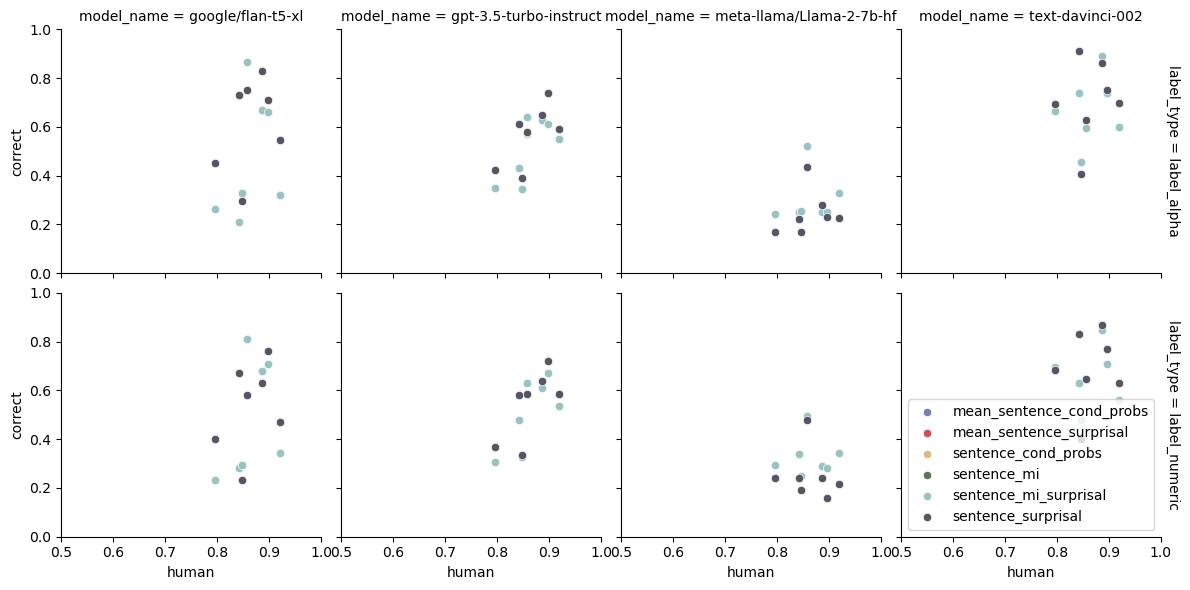

In [410]:
# plotting results by metric, by phenomenon, by model, by label type 
scores_binary_summary_wHuman
p1 = sns.FacetGrid(
    scores_binary_summary_wHuman, 
    col="model_name", 
    hue="metric_formula", 
    row="label_type",
    margin_titles=True,
)
p1.map_dataframe(sns.scatterplot, "human", "correct")
# sns.scatterplot(data=scores_binary_summary_wHuman, x="human", y="target", hue="phenomenon", style="metric_formula")
plt.xlim(0.5, 1)
plt.ylim(0, 1)
plt.legend()

In [277]:
scores_binary_summary_wHuman

shuffled_option_names,model_name,metric_formula,phenomenon,label_type,seed,item_id,correct,human
0,google/flan-t5-xl,mean_sentence_cond_probs,coherence,label_alpha,2.0,20.5,0.750000,0.856684
1,google/flan-t5-xl,mean_sentence_cond_probs,coherence,label_numeric,2.0,20.5,0.580000,0.856684
2,google/flan-t5-xl,mean_sentence_cond_probs,deceits,label_alpha,2.0,10.5,0.730000,0.841979
3,google/flan-t5-xl,mean_sentence_cond_probs,deceits,label_numeric,2.0,10.5,0.670000,0.841979
4,google/flan-t5-xl,mean_sentence_cond_probs,humour,label_alpha,2.0,13.0,0.296000,0.846845
...,...,...,...,...,...,...,...,...
331,text-davinci-002,sentence_surprisal,irony,label_numeric,2.0,13.0,0.632000,0.919465
332,text-davinci-002,sentence_surprisal,maxims,label_alpha,2.0,10.0,0.694737,0.795856
333,text-davinci-002,sentence_surprisal,maxims,label_numeric,2.0,10.0,0.684211,0.795856
334,text-davinci-002,sentence_surprisal,metaphor,label_alpha,2.0,10.5,0.750000,0.896791


## Analyse the binarized argmaxed data 

In [27]:
# find best seed and best set of labels
# output the cleaned file
# plot detailed results (also by-category distribution breakdown)

In [411]:
# check if any seed is much better
label_scores_bySeed = label_scores.groupby(["model_name", "metric_formula", "seed"]).mean("correct").reset_index()

In [412]:
label_scores_bySeed_wide = label_scores_bySeed.pivot_table(
    columns=["seed"],
    values="correct",
    index=["model_name", "metric_formula", "item_id"]
).reset_index()
label_scores_bySeed_wide

seed,model_name,metric_formula,item_id,0,1,2,3,4
0,google/flan-t5-xl,mean_sentence_cond_probs,13.550296,0.571006,0.579882,0.585799,0.568047,0.573964
1,google/flan-t5-xl,mean_sentence_surprisal,13.550296,0.571006,0.579882,0.585799,0.568047,0.573964
2,google/flan-t5-xl,sentence_cond_probs,13.550296,0.571006,0.579882,0.585799,0.568047,0.573964
3,google/flan-t5-xl,sentence_mi,13.550296,0.505917,0.511834,0.502959,0.511834,0.523669
4,google/flan-t5-xl,sentence_mi_surprisal,13.550296,0.505917,0.511834,0.502959,0.511834,0.523669
5,google/flan-t5-xl,sentence_surprisal,13.550296,0.571006,0.579882,0.585799,0.568047,0.573964
6,gpt-3.5-turbo-instruct,mean_sentence_cond_probs,13.550296,0.547337,0.571006,0.541420,0.550296,0.568047
7,gpt-3.5-turbo-instruct,mean_sentence_surprisal,13.550296,0.550296,0.571006,0.538462,0.547337,0.565089
8,gpt-3.5-turbo-instruct,sentence_cond_probs,13.550296,0.547337,0.571006,0.541420,0.547337,0.568047
9,gpt-3.5-turbo-instruct,sentence_mi,13.550296,0.526627,0.500000,0.529586,0.497041,0.547337


In [413]:
def compute_diffs(r):
    cols = [0, 1, 2, 3, 4]
    vals = [r[o] for o in cols]
    return max(vals) - min(vals)

def max_col(r):
    cols = [0, 1, 2, 3, 4]
    vals = [r[o] for o in cols]
    return cols[vals.index(max(vals))]

In [414]:
label_scores_bySeed_wide["diff"] = label_scores_bySeed_wide.apply(lambda r: compute_diffs(r), axis = 1)
label_scores_bySeed_wide["max_seed"] = label_scores_bySeed_wide.apply(lambda r: max_col(r), axis = 1)

label_scores_bySeed_wide

seed,model_name,metric_formula,item_id,0,1,2,3,4,diff,max_seed
0,google/flan-t5-xl,mean_sentence_cond_probs,13.550296,0.571006,0.579882,0.585799,0.568047,0.573964,0.017751,2
1,google/flan-t5-xl,mean_sentence_surprisal,13.550296,0.571006,0.579882,0.585799,0.568047,0.573964,0.017751,2
2,google/flan-t5-xl,sentence_cond_probs,13.550296,0.571006,0.579882,0.585799,0.568047,0.573964,0.017751,2
3,google/flan-t5-xl,sentence_mi,13.550296,0.505917,0.511834,0.502959,0.511834,0.523669,0.020710,4
4,google/flan-t5-xl,sentence_mi_surprisal,13.550296,0.505917,0.511834,0.502959,0.511834,0.523669,0.020710,4
5,google/flan-t5-xl,sentence_surprisal,13.550296,0.571006,0.579882,0.585799,0.568047,0.573964,0.017751,2
6,gpt-3.5-turbo-instruct,mean_sentence_cond_probs,13.550296,0.547337,0.571006,0.541420,0.550296,0.568047,0.029586,1
7,gpt-3.5-turbo-instruct,mean_sentence_surprisal,13.550296,0.550296,0.571006,0.538462,0.547337,0.565089,0.032544,1
8,gpt-3.5-turbo-instruct,sentence_cond_probs,13.550296,0.547337,0.571006,0.541420,0.547337,0.568047,0.029586,1
9,gpt-3.5-turbo-instruct,sentence_mi,13.550296,0.526627,0.500000,0.529586,0.497041,0.547337,0.050296,4


In [415]:
label_scores_bySeed_wide["max_seed"].value_counts()
# mean accuracy by seed
label_scores_bySeed.groupby(["seed"]).mean("correct")
# seed 3 has highest accuracy

shuffled_option_names,item_id,correct
seed,,
0,13.550296,0.512574
1,13.550296,0.513683
2,13.550296,0.518614
3,13.550296,0.516642
4,13.550296,0.514916


In [416]:
# check alphabetic vs numeric labels
label_scores_byLabel = label_scores.groupby(["model_name", "metric_formula", "label_type"]).mean("correct").reset_index()

In [417]:
label_scores_byLabel_wide = label_scores_byLabel.pivot_table(
    columns=["label_type"],
    values="correct",
    index=["model_name", "metric_formula", "item_id"]
).reset_index()
label_scores_byLabel_wide["diff"] = abs(label_scores_byLabel_wide["label_alpha"] - label_scores_byLabel_wide["label_numeric"])

In [418]:
label_scores_byLabel_wide["diff"].sort_values()

10    0.001183
9     0.001183
3     0.002367
4     0.002367
21    0.008284
22    0.008284
17    0.010651
14    0.010651
13    0.010651
12    0.010651
23    0.014201
18    0.014201
19    0.014201
20    0.014201
7     0.020118
15    0.020118
16    0.020118
8     0.021302
11    0.021302
6     0.022485
5     0.091124
2     0.091124
1     0.091124
0     0.091124
Name: diff, dtype: float64

In [419]:
# mean accuracy by label type
label_scores_byLabel.groupby(["label_type"]).mean("correct") 
# label alpha has slightly higher accuracy

shuffled_option_names,seed,item_id,correct
label_type,,,
label_alpha,2.0,13.550296,0.524606
label_numeric,2.0,13.550296,0.505966


In [420]:
label_scores_byLabel.groupby(["label_type", "model_name"]).mean("correct") 

shuffled_option_names                   seed    item_id   correct
label_type    model_name                                         
label_alpha   google/flan-t5-xl          2.0  13.550296  0.585010
              gpt-3.5-turbo-instruct     2.0  13.550296  0.550888
              meta-llama/Llama-2-7b-hf   2.0  13.550296  0.285996
              text-davinci-002           2.0  13.550296  0.676529
label_numeric google/flan-t5-xl          2.0  13.550296  0.523471
              gpt-3.5-turbo-instruct     2.0  13.550296  0.536292
              meta-llama/Llama-2-7b-hf   2.0  13.550296  0.299803
              text-davinci-002           2.0  13.550296  0.664300

The most variation of accuracy by metric induced by seeds is 0.1 and it was not deemed significant for selecting a particular seed. Similarly, there is no difference by label type. 

**But based on average accuracy by label type, the alphabetic labels are chosen.**

In [421]:
label_scores

shuffled_option_names,metric_formula,model_name,seed,item_id,phenomenon,metric,label_type,chosen_option,correct
0,mean_sentence_cond_probs,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,target,1
1,mean_sentence_surprisal,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,target,1
2,sentence_cond_probs,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,target,1
3,sentence_mi,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,target,1
4,sentence_mi_surprisal,google/flan-t5-xl,0,1,coherence,label_score,label_alpha,target,1
...,...,...,...,...,...,...,...,...,...
4795,mean_sentence_surprisal,text-davinci-002,4,20,metaphor,label_score,label_numeric,target,1
4796,sentence_cond_probs,text-davinci-002,4,20,metaphor,label_score,label_numeric,target,1
4797,sentence_mi,text-davinci-002,4,20,metaphor,label_score,label_numeric,target,1
4798,sentence_mi_surprisal,text-davinci-002,4,20,metaphor,label_score,label_numeric,target,1


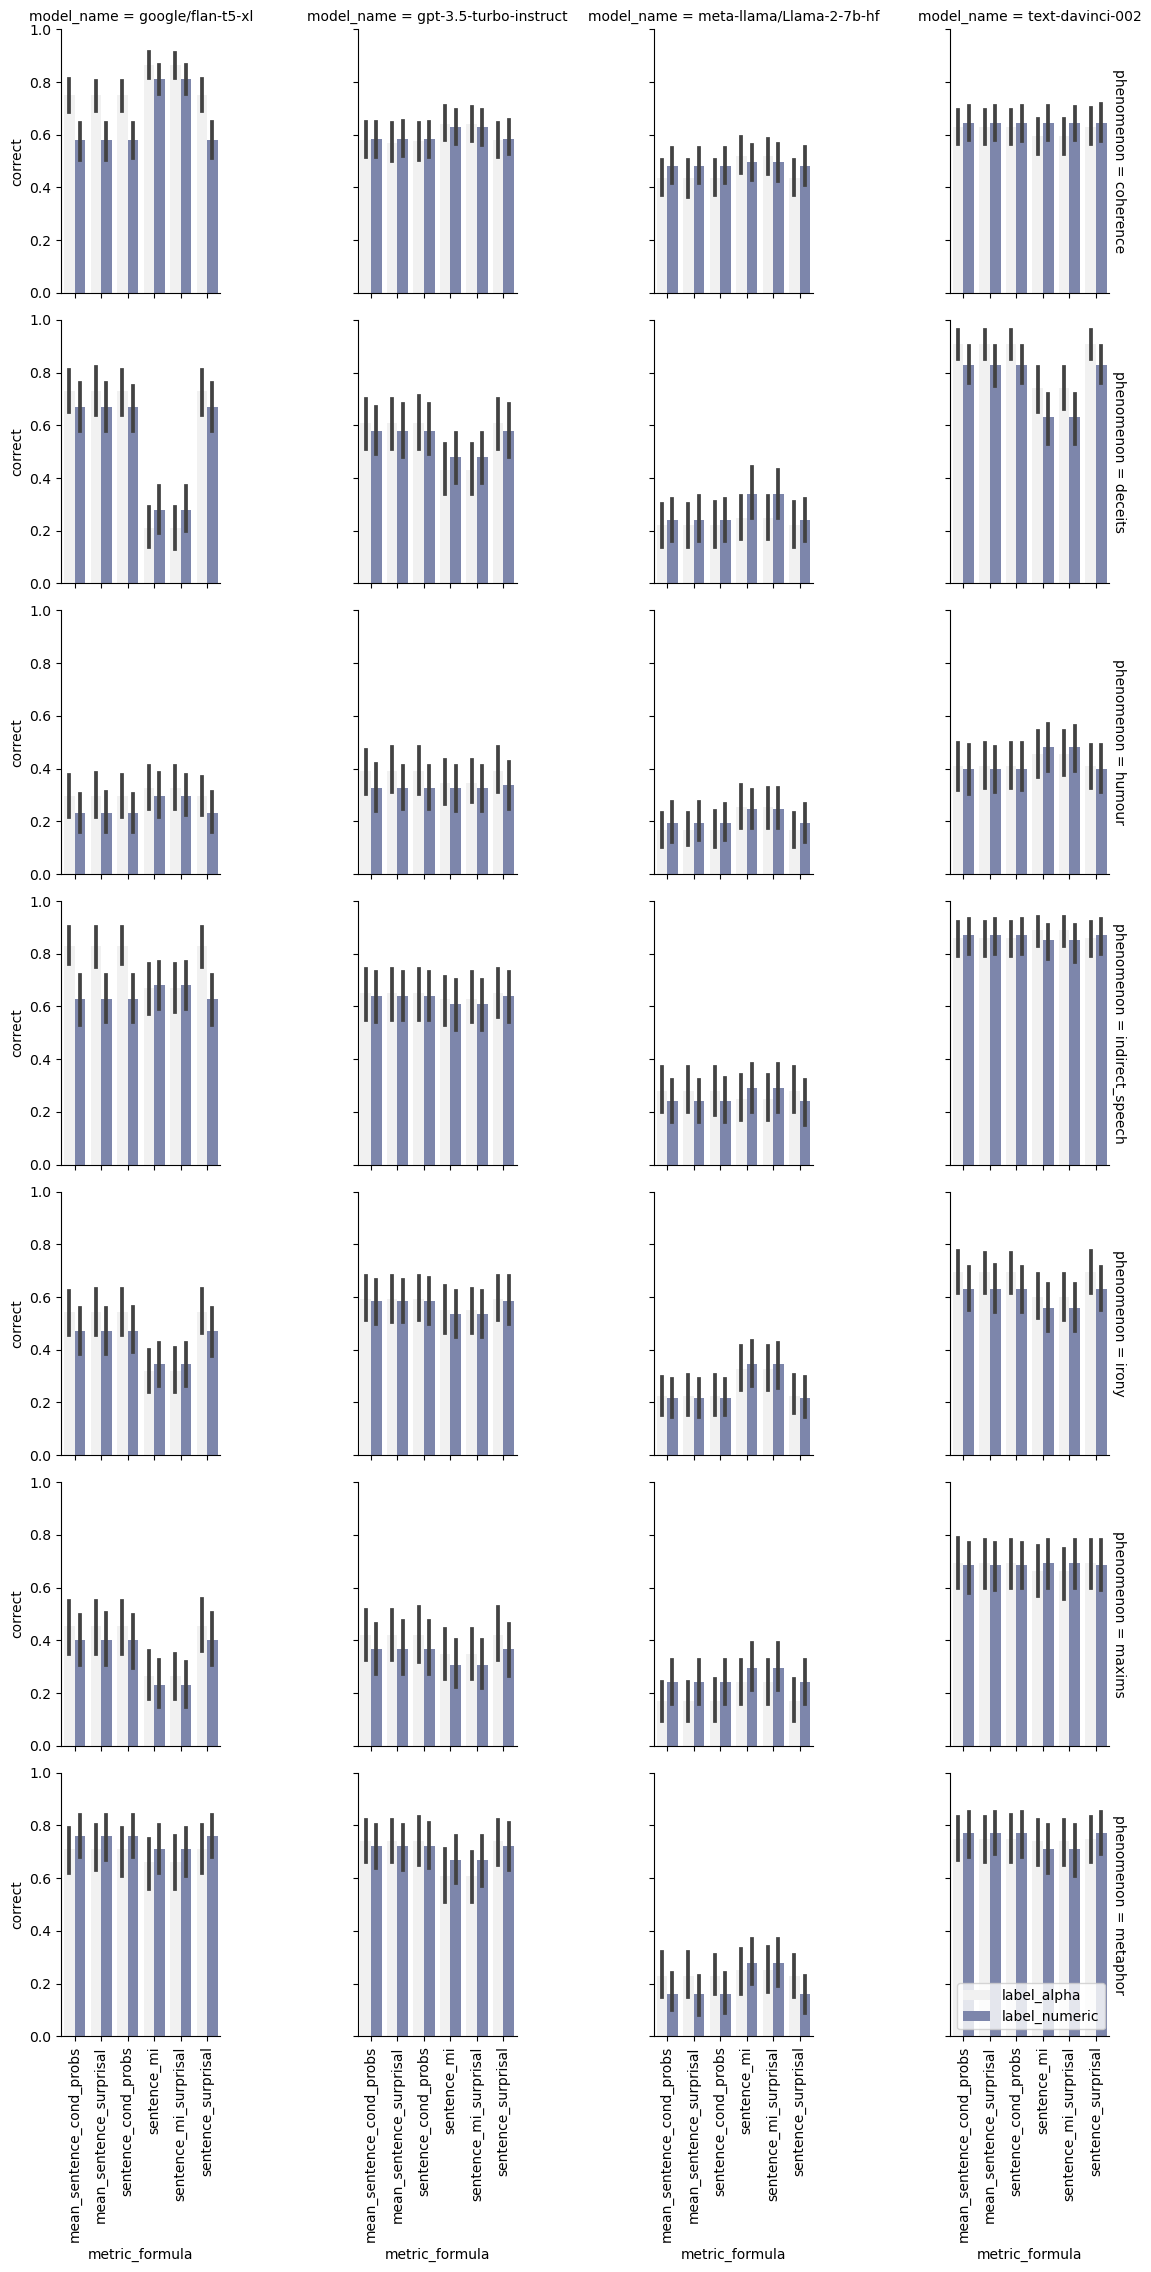

In [422]:
# plot accuracy (y axis) by phenomenon (rows) by model (cols) by label type (color) by metric (x axis) 
p_argmax = sns.FacetGrid(
    label_scores, 
    col = "model_name", 
    row="phenomenon",
    margin_titles=True,
)
p_argmax.map_dataframe(sns.barplot, x="metric_formula", y = "correct", hue = "label_type")
axes = p_argmax.axes.flatten()
for ax in axes:
    ax.set_ylim(0,1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend()

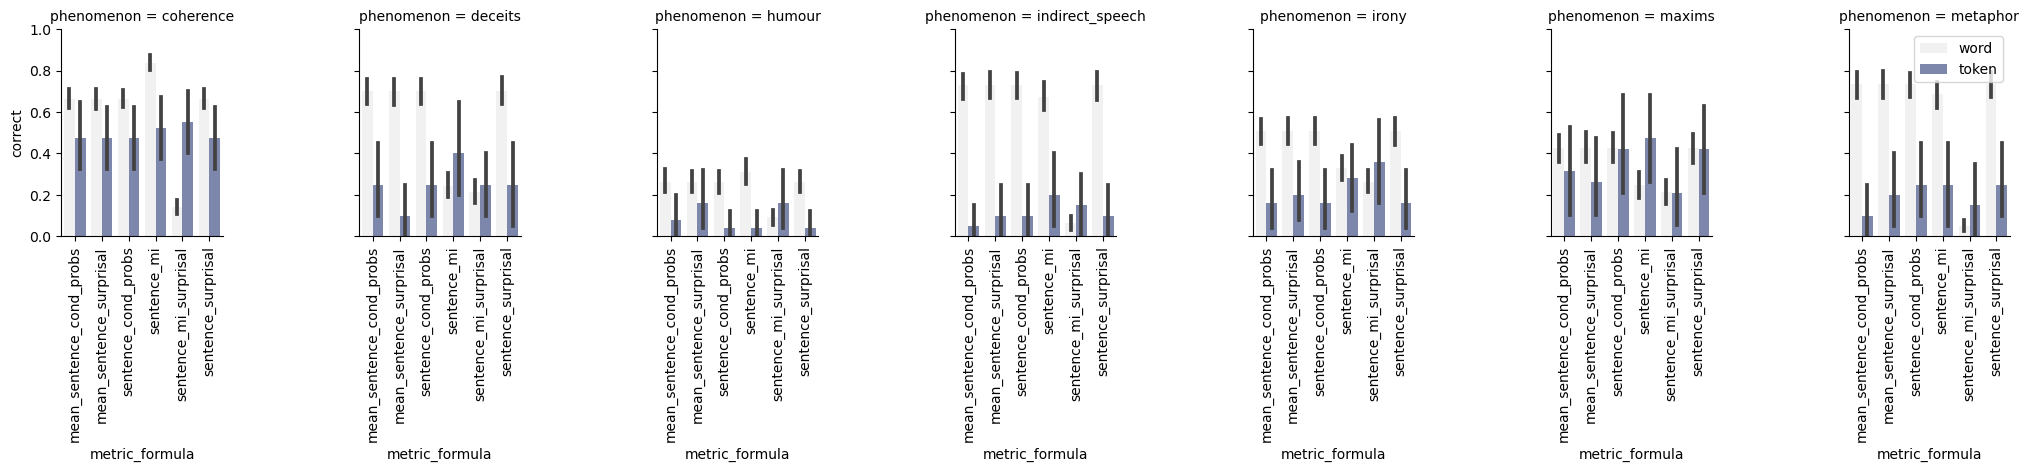

In [325]:
# plot T5 data by masking procedure
p_masking = sns.FacetGrid(
    t5_masking_comparison, 
    col = "phenomenon", 
    margin_titles=True,
)
p_masking.map_dataframe(sns.barplot, x="metric_formula", y = "correct", hue = "masking")
axes = p_masking.axes.flatten()
for ax in axes:
    ax.set_ylim(0,1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend()

In [423]:
label_scores_wide = label_scores.pivot_table(
    columns=["metric_formula"],
    values="correct",
    index=["model_name", "seed", "item_id", "phenomenon", "metric", "label_type"]
).reset_index()

In [424]:
label_scores
label_scores_out_long =label_scores[["metric_formula", "model_name", "item_id", "phenomenon", "metric", "correct"]]
label_scores_out_long = label_scores_out_long.rename(columns={"correct": "dependent_variable"})
# label_scores_out_long.to_csv("processed_data/label_scores_argmax_long.csv", index=False)

In [425]:
label_scores_out_wide = label_scores_wide[["model_name", "item_id", "phenomenon", "metric", "sentence_cond_probs", "mean_sentence_cond_probs", "sentence_mi", "sentence_surprisal", "mean_sentence_surprisal", "sentence_mi_surprisal" ]]
# label_scores_out_wide.to_csv("processed_data/label_scores_argmax_wide.csv", index=False)

In [426]:
df_human_all_forErrBars = pd.concat([df_human_all] * 4)
df_human_all_forErrBars["metric_formula"] = ["human"] * len(df_human_all) * 4  
df_human_all_forErrBars["model_name"] = ["google/flan-t5-xl"] * len(df_human_all) + ["gpt-3.5-turbo-instruct"] * len(df_human_all) + ["text-davinci-002"] * len(df_human_all) + ["meta-llama/Llama-2-7b-hf"] * len(df_human_all)

In [427]:
df_human_all_forErrBars

,Unnamed: 0,pKey,itemNum,Correct,Task,OptionChosen,phenomenon,metric_formula,model_name
0,1,100,27,0,CIV,Coherent,coherence,human,google/flan-t5-xl
1,2,100,21,1,CIV,Incoherent,coherence,human,google/flan-t5-xl
2,3,100,2,1,CIV,Coherent,coherence,human,google/flan-t5-xl
3,4,100,40,0,CIV,Coherent,coherence,human,google/flan-t5-xl
4,5,100,35,0,CIV,Coherent,coherence,human,google/flan-t5-xl
...,...,...,...,...,...,...,...,...,...
7475,7476,99,13,0,MV,Answer1,maxims,human,meta-llama/Llama-2-7b-hf
7476,7477,99,9,0,MV,Answer3,maxims,human,meta-llama/Llama-2-7b-hf
7477,7478,99,20,1,MV,Answer2,maxims,human,meta-llama/Llama-2-7b-hf
7478,7479,99,10,0,MV,Answer1,maxims,human,meta-llama/Llama-2-7b-hf


In [428]:
# add human data to label_scores
label_scores_wHuman = label_scores[["metric_formula", "model_name", "phenomenon", "correct"]]
df_human_all_forErrBars = df_human_all_forErrBars.rename(columns={"Correct": "correct"})[["metric_formula", "model_name", "phenomenon", "correct"]]
label_scores_wHuman = pd.concat([label_scores_wHuman, df_human_all_forErrBars])
label_scores_wHuman

,metric_formula,model_name,phenomenon,correct
0,mean_sentence_cond_probs,google/flan-t5-xl,coherence,1
1,mean_sentence_surprisal,google/flan-t5-xl,coherence,1
2,sentence_cond_probs,google/flan-t5-xl,coherence,1
3,sentence_mi,google/flan-t5-xl,coherence,1
4,sentence_mi_surprisal,google/flan-t5-xl,coherence,1
...,...,...,...,...
7475,human,meta-llama/Llama-2-7b-hf,maxims,0
7476,human,meta-llama/Llama-2-7b-hf,maxims,0
7477,human,meta-llama/Llama-2-7b-hf,maxims,1
7478,human,meta-llama/Llama-2-7b-hf,maxims,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


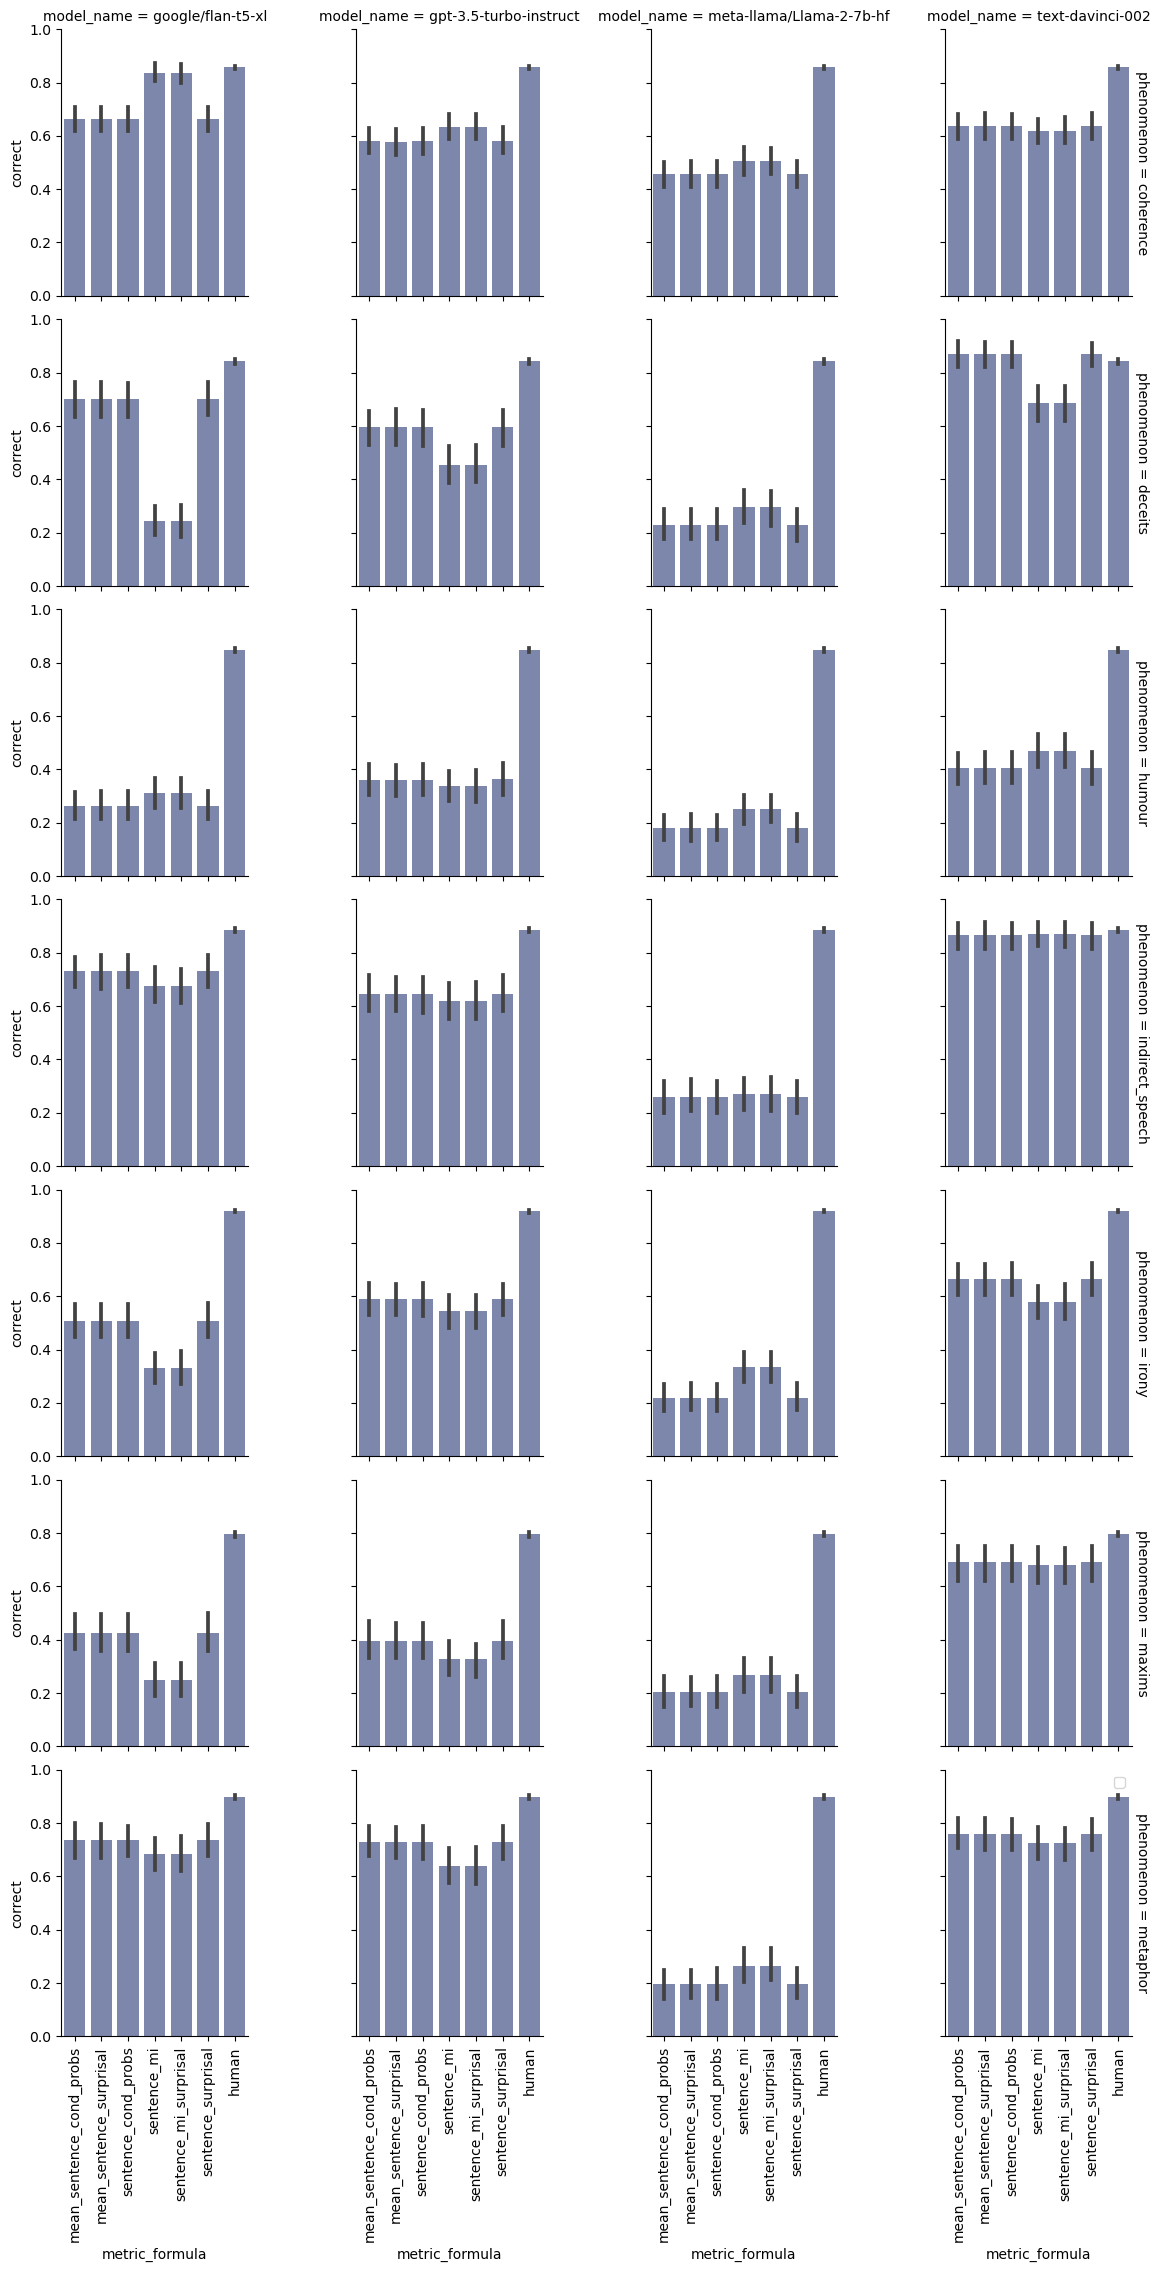

In [429]:
# plot accuracy across label types, by phenomenon, together with human data
p_argmax_summary = sns.FacetGrid(
    label_scores_wHuman, 
    col = "model_name", 
    row="phenomenon",
    margin_titles=True,
)
p_argmax_summary.map_dataframe(sns.barplot, x="metric_formula", y = "correct")
axes = p_argmax_summary.axes.flatten()
for ax in axes:
    ax.set_ylim(0,1)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend()

In [298]:
tdv2 = label_scores_wHuman[label_scores_wHuman["model_name"] == "text-davinci-002"]
tdv2_metaphor = tdv2[tdv2["phenomenon"] == "metaphor"]
# any([o == 1 for o in tdv2_metaphor[tdv2_metaphor["metric_formula"] == "sentence_mi_surprisal"]["correct"]])

In [430]:
# for the grand plot in the paper, we want to know which metric results in highest accuracy
# both across and by model
# across phenomena
label_scores.groupby(["model_name", "metric_formula"]).mean("correct")

shuffled_option_names                              seed    item_id   correct
model_name               metric_formula                                     
google/flan-t5-xl        mean_sentence_cond_probs   2.0  13.550296  0.575740
                         mean_sentence_surprisal    2.0  13.550296  0.575740
                         sentence_cond_probs        2.0  13.550296  0.575740
                         sentence_mi                2.0  13.550296  0.511243
                         sentence_mi_surprisal      2.0  13.550296  0.511243
                         sentence_surprisal         2.0  13.550296  0.575740
gpt-3.5-turbo-instruct   mean_sentence_cond_probs   2.0  13.550296  0.555621
                         mean_sentence_surprisal    2.0  13.550296  0.554438
                         sentence_cond_probs        2.0  13.550296  0.555030
                         sentence_mi                2.0  13.550296  0.520118
                         sentence_mi_surprisal      2.0  13.550296  0.520118
                         sentence_surprisal         2.0  13.550296  0.556213
meta-llama/Llama-2-7b-hf mean_sentence_cond_probs   2.0  13.550296  0.271598
                         mean_sentence_surprisal    2.0  13.550296  0.271598
                         sentence_cond_probs        2.0  13.550296  0.271598
                         sentence_mi                2.0  13.550296  0.335503
                         sentence_mi_surprisal      2.0  13.550296  0.335503
                         sentence_surprisal         2.0  13.550296  0.271598
text-davinci-002         mean_sentence_cond_probs   2.0  13.550296  0.681657
                         mean_sentence_surprisal    2.0  13.550296  0.681657
                         sentence_cond_probs        2.0  13.550296  0.681657
                         sentence_mi                2.0  13.550296  0.647929
                         sentence_mi_surprisal      2.0  13.550296  0.647929
                         sentence_surprisal         2.0  13.550296  0.681657

Results by model:
* T5: any of sentence surprisal, sentence cond prob, mean_sentence_cond_probs, mean_sentence_surprisal
* LLama: sentence_mi or sentence_mi_surprisal
* gpt-3.5: mean sentence surprisal
* davinci-002: any of: sentence surprisal, sentence cond prob, mean_sentence_cond_probs, mean_sentence_surprisal

In [434]:
# across models: sentence_mi
label_scores.groupby(["metric_formula"]).mean("correct")

shuffled_option_names,seed,item_id,correct
metric_formula,,,
mean_sentence_cond_probs,2.0,13.550296,0.521154
mean_sentence_surprisal,2.0,13.550296,0.520858
sentence_cond_probs,2.0,13.550296,0.521006
sentence_mi,2.0,13.550296,0.503698
sentence_mi_surprisal,2.0,13.550296,0.503698
sentence_surprisal,2.0,13.550296,0.521302


In [435]:
# subset data to best configs, respectively
# long format first
label_scores_bestConfigs = label_scores[
    (label_scores["metric_formula"] == "sentence_surprisal") & 
    (label_scores["label_type"] == "label_alpha")
]
label_scores_bestConfigs_out = label_scores_bestConfigs[["metric_formula", "model_name", "item_id", "phenomenon", "metric", "correct"]]
label_scores_bestConfigs_out = label_scores_bestConfigs_out.rename(columns={"correct": "dependent_variable"})
# label_scores_bestConfigs_out.to_csv("processed_data/label_scores_argmax_bestConfigs_long.csv", index=False)

In [436]:
# now summary of best config
label_scores_bestConfigs_out = label_scores_bestConfigs_out.rename(columns={"correct": "dependent_variable"})
# average over seeds and items
label_scores_bestConfigs_out_summary = label_scores_bestConfigs_out.groupby(["model_name", "phenomenon", "metric_formula", "metric"]).mean("correct").reset_index()
label_scores_bestConfigs_out_summary = label_scores_bestConfigs_out_summary[["model_name", "metric_formula", "phenomenon", "metric", "dependent_variable"]]
# label_scores_bestConfigs_out_summary.to_csv("processed_data/label_scores_accuracy_bestConfigs_summary.csv", index=False)

<AxesSubplot:xlabel='phenomenon', ylabel='correct'>

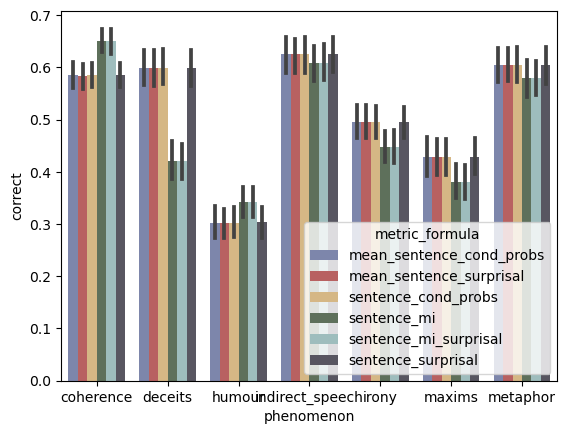

In [437]:
# across models
sns.barplot(label_scores, x="phenomenon", y = "correct", hue="metric_formula")


In [438]:
# plot distributions of chosen options
label_scores_byOption_summary = label_scores.groupby(
    ['model_name', 'phenomenon']
)["chosen_option"].value_counts(normalize=True).unstack().fillna(0).reset_index()

In [439]:
label_scores_byOption_summary

chosen_option,model_name,phenomenon,associative_nonsequitur,competitor,distractor_associate,distractor_associative,distractor_lexical_overlap,distractor_literal,distractor_nonsequitur,distractor_nonsequitut,distractor_plausibleliteral,funny_nonsequitur,incorrect_associate,incorrect_lexical_overlap,incorrect_literal,incorrect_nonliteral,incorrect_social_convention,incorrect_straightforward,neutral_nonsequitur,target
0,google/flan-t5-xl,coherence,0.000000,0.277500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.722500
1,google/flan-t5-xl,deceits,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025000,0.410000,0.000000,0.016667,0.000000,0.000000,0.548333
2,google/flan-t5-xl,humour,0.046667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.206667,0.000000,0.000000,0.000000,0.000000,0.000000,0.458667,0.008000,0.280000
3,google/flan-t5-xl,indirect_speech,0.000000,0.275000,0.000000,0.001667,0.011667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.711667
4,google/flan-t5-xl,irony,0.000000,0.506667,0.014667,0.000000,0.000000,0.000000,0.029333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.449333
5,google/flan-t5-xl,maxims,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.152632,0.000000,0.438596,0.042105,0.000000,0.000000,0.000000,0.366667
6,google/flan-t5-xl,metaphor,0.000000,0.028333,0.000000,0.000000,0.000000,0.098333,0.000000,0.030000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.718333
7,gpt-3.5-turbo-instruct,coherence,0.000000,0.401250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.598750
8,gpt-3.5-turbo-instruct,deceits,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.375000,0.000000,0.043333,0.000000,0.000000,0.548333
9,gpt-3.5-turbo-instruct,humour,0.026667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.049333,0.000000,0.000000,0.000000,0.000000,0.000000,0.566000,0.005333,0.352667


In [440]:
df_human_all[df_human_all["phenomenon"] == "coherence"]["Correct"].mean()

0.8566844919786096

In [441]:
human_category_summary_avg_unique = human_category_summary_avg[["phenomenon", "value", "model_name", "shuffled_option_names"]].drop_duplicates()
human_category_summary_avg_unique = human_category_summary_avg_unique.rename(columns={"value": "proportion", "shuffled_option_names": "response_option"})
# TODO: manually add human coherence results
human_category_summary_avg_unique.loc[26] = {"phenomenon": "coherence", "proportion": 0.86, "model_name": "human", "response_option":"target"}
human_category_summary_avg_unique.loc[27] = {"phenomenon": "coherence", "proportion": 0.14, "model_name": "human", "response_option":"competitor"}

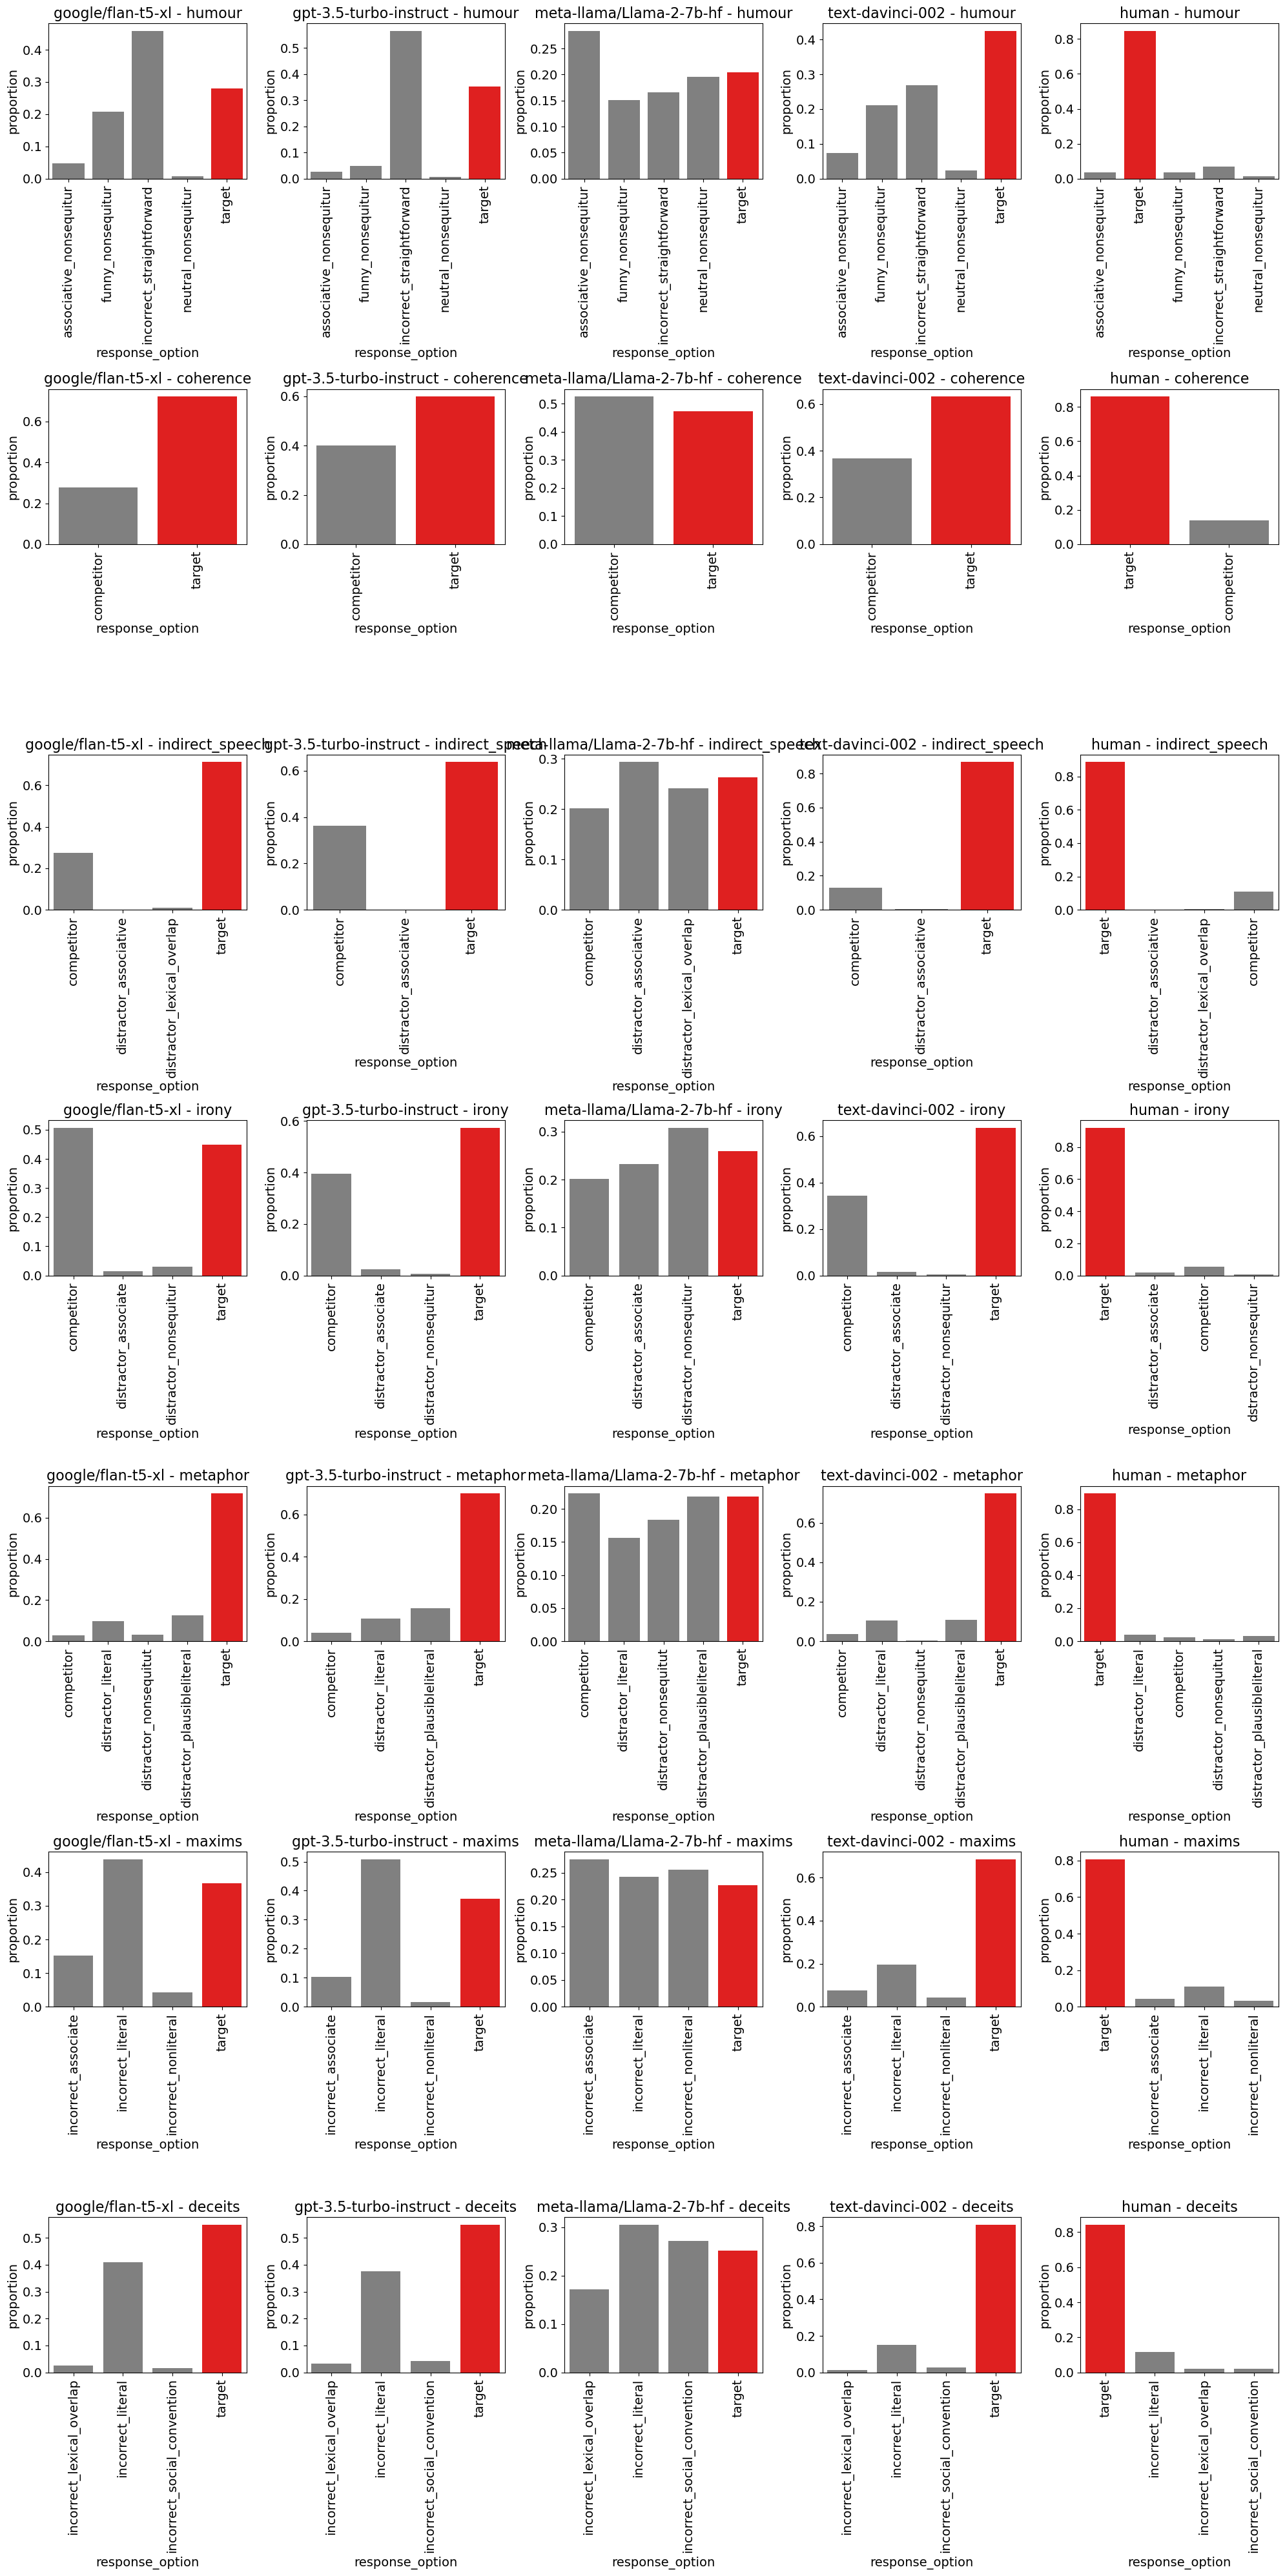

In [442]:
# Melt the DataFrame to have 'response_option' and 'normalized_count' as separate columns
label_scores_byOption_summary_long = label_scores_byOption_summary.melt(id_vars=['phenomenon', 'model_name'], 
                                                 value_vars=label_scores_byOption_summary.columns, 
                                                 var_name='response_option', 
                                                 value_name='proportion')

# Filter out rows where normalized_count is zero to only plot non-zero responses
label_scores_byOption_summary_long_nonZero = label_scores_byOption_summary_long[label_scores_byOption_summary_long['proportion'] > 0]

label_scores_byOption_summary_long_nonZero = pd.concat([label_scores_byOption_summary_long_nonZero, human_category_summary_avg_unique])

## Extract unique models and phenomena
unique_models = label_scores_byOption_summary_long_nonZero['model_name'].unique()
unique_phenomena = label_scores_byOption_summary_long_nonZero['phenomenon'].unique()

# Use a custom color palette to highlight 'target' response_option
palette = {response: 'gray' if response != 'target' else 'red' for response in label_scores_byOption_summary_long_nonZero['response_option'].unique()}

# Set up the grid layout for the subplots
fig, axes = plt.subplots(len(unique_phenomena), len(unique_models), figsize=(20, 40), sharey=False)

# Iterate over each model and phenomenon to create individual subplots
for i, phenomenon in enumerate(unique_phenomena):
    for j, model in enumerate(unique_models):
        ax = axes[i, j]
        subset_data = label_scores_byOption_summary_long_nonZero[(label_scores_byOption_summary_long_nonZero['model_name'] == model) & 
                                           (label_scores_byOption_summary_long_nonZero['phenomenon'] == phenomenon)]
        sns.barplot(data=subset_data, x='response_option', y='proportion', ax=ax, palette=palette)
        ax.set_title(f"{model} - {phenomenon}")
        ax.tick_params(axis="x", rotation=90)

        # Set title with larger font size
        ax.set_title(f"{model} - {phenomenon}", fontsize=16)
        
        # Increase tick label size
        ax.tick_params(axis="x", rotation=90, labelsize=14)
        ax.tick_params(axis="y", labelsize=14)
        
        # Increase axis label size
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)

plt.tight_layout()
plt.show()

In [443]:
# create short summary
label_scores_summary_out = label_scores.groupby(["model_name", "metric_formula", "phenomenon", "metric"]).mean("correct").reset_index()

In [444]:
label_scores_summary_out = label_scores_summary_out[["model_name", "metric_formula", "phenomenon", "metric", "correct"]]

In [445]:
label_scores_summary_out = label_scores_summary_out.rename(columns={"correct":"dependent_variable"})

In [446]:
# label_scores_summary_out.to_csv("processed_data/label_scores_accuracy_summary.csv", index=False)

## Analyses of other metrics

In [357]:
# first, identify best metric for string score
string_scores_summary = pd.read_csv("string_scores_accuracy_summary.csv")

In [359]:
string_scores_summary.groupby(["metric_formula"]).mean("dependent_variable")

,dependent_variable
metric_formula,
mean_sentence_cond_probs,0.398947
mean_sentence_surprisal,0.446927
sentence_cond_probs,0.414596
sentence_mi,0.422077
sentence_mi_surprisal,0.145301
sentence_surprisal,0.414596


-> Mean sentence surprisal is the best one here.

In [362]:
string_scores_summary_bestConfig = string_scores_summary[string_scores_summary["metric_formula"] == "mean_sentence_surprisal"].reset_index()

In [364]:
# string_scores_summary_bestConfig.to_csv("processed_data/string_scores_accuracy_bestConfig_summary.csv", index=False)

In [455]:
# now process embedding similarity data
emb_sim = pd.DataFrame()
# read data and combine
# use the GPT model name to add it there, just in case
model_names = ["gpt-3.5-turbo-instruct", "llama2", "flan-t5-xl"]

for model in model_names:
    print("Model ", model)
    results_path = glob.glob(f"../results/embedding_similarity/{model}/*.csv")
    print("Number of files to concat ", len(results_path))
    for p in results_path:
        d = pd.read_csv(p)
        d["metric"] = "embedding_similarity"
        d["label_type"] = label_type

        emb_sim = pd.concat([emb_sim, d])    

Model  gpt-3.5-turbo-instruct
Number of files to concat  7
Model  llama2
Number of files to concat  7
Model  flan-t5-xl
Number of files to concat  7


In [456]:
emb_sim["dependent_variable"] = emb_sim["chosen_option"].apply(lambda s: int(s == "target"))
emb_sim_summary = emb_sim.groupby(["model_name", "phenomenon"]).mean("dependent_variable")
emb_sim_summary

seed  item_id  cosine_sims  \
model_name               phenomenon                                    
google/flan-t5-xl        coherence         0.0     20.5    -0.000516   
                         deceits           0.0     10.5    -0.014670   
                         humour            0.0     13.0    -0.013480   
                         indirect_speech   0.0     10.5    -0.011954   
                         irony             0.0     13.0    -0.013277   
                         maxims            0.0     10.0    -0.013086   
                         metaphor          0.0     10.5    -0.012300   
meta-llama/Llama-2-7b-hf coherence         0.0     20.5     0.164667   
                         deceits           0.0     10.5     0.123443   
                         humour            0.0     13.0     0.197555   
                         indirect_speech   0.0     10.5     0.117576   
                         irony             0.0     13.0     0.114002   
                         maxims            0.0     10.0     0.090489   
                         metaphor          0.0     10.5     0.110489   
text-embedding-ada-002   coherence         0.0     20.5     0.799459   
                         deceits           0.0     10.5     0.822888   
                         humour            0.0     13.0     0.758634   
                         indirect_speech   0.0     10.5     0.803485   
                         irony             0.0     13.0     0.788470   
                         maxims            0.0     10.0     0.823543   
                         metaphor          0.0     10.5     0.802836   

                                          choice_probs_rounded  \
model_name               phenomenon                              
google/flan-t5-xl        coherence                    0.500000   
                         deceits                      0.250000   
                         humour                       0.200000   
                         indirect_speech              0.250000   
                         irony                        0.250000   
                         maxims                       0.250000   
                         metaphor                     0.200000   
meta-llama/Llama-2-7b-hf coherence                    0.499994   
                         deceits                      0.249996   
                         humour                       0.200000   
                         indirect_speech              0.249989   
                         irony                        0.250012   
                         maxims                       0.250022   
                         metaphor                     0.199993   
text-embedding-ada-002   coherence                    0.500000   
                         deceits                      0.250000   
                         humour                       0.200000   
                         indirect_speech              0.250000   
                         irony                        0.250000   
                         maxims                       0.250000   
                         metaphor                     0.200000   

                                          dependent_variable  
model_name               phenomenon                           
google/flan-t5-xl        coherence                  0.500000  
                         deceits                    0.250000  
                         humour                     0.120000  
                         indirect_speech            0.100000  
                         irony                      0.320000  
                         maxims                     0.315789  
                         metaphor                   0.200000  
meta-llama/Llama-2-7b-hf coherence                  0.500000  
                         deceits                    0.150000  
                         humour                     0.200000  
                         indirect_speech            0.450000  
                         irony                 

In [451]:
emb_sim_summary = emb_sim_summary.reset_index()[["model_name", "phenomenon", "dependent_variable"]]
emb_sim_summary["metric"] = "embedding_similarity"
emb_sim_summary["metric formula"] = "cosine"
emb_sim_summary["model_name"] = emb_sim_summary["model_name"].apply(
    lambda s: "gpt-3.5-turbo-instruct" if s == "text-embedding-ada-002" else s
) 

In [453]:
# emb_sim_summary.to_csv("processed_data/embedding_similarity_accuracy_summary.csv", index=False)

In [467]:
# also prepare raw data
emb_sim_subset = emb_sim[["model_name", "item_id", "phenomenon", "metric", "dependent_variable"]]

In [468]:
emb_sim_long = emb_sim_subset.drop_duplicates()
emb_sim_long["metric_formula"] = "cosine"

/var/folders/fn/6ct_6l112376k8288ws7798m0000gn/T/ipykernel_50640/3418657033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  emb_sim_long["metric_formula"] = "cosine"


In [469]:
# emb_sim_long.to_csv("processed_data/embedding_similarity_accuracy_long.csv", index=False)

In [466]:
emb_sim_long

,model_name,item_id,phenomenon,chosen_option,metric,dependent_variable
0,text-embedding-ada-002,1,humour,funny_nonsequitur,embedding_similarity,0
5,text-embedding-ada-002,2,humour,incorrect_straightforward,embedding_similarity,0
10,text-embedding-ada-002,3,humour,associative_nonsequitur,embedding_similarity,0
15,text-embedding-ada-002,4,humour,incorrect_straightforward,embedding_similarity,0
20,text-embedding-ada-002,5,humour,incorrect_straightforward,embedding_similarity,0
...,...,...,...,...,...,...
60,google/flan-t5-xl,16,indirect_speech,competitor,embedding_similarity,0
64,google/flan-t5-xl,17,indirect_speech,distractor_associative,embedding_similarity,0
68,google/flan-t5-xl,18,indirect_speech,distractor_lexical_overlap,embedding_similarity,0
72,google/flan-t5-xl,19,indirect_speech,distractor_lexical_overlap,embedding_similarity,0
